### Part NLP

Imports

In [2]:
import gzip
import pandas as pd
import re
import wikitextparser as wtp
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

imports data from folder :

In [3]:
%matplotlib inline

DATA_FOLDER = 'Data/'
WIKI_RFA = DATA_FOLDER+"wiki-RfA.txt.gz"

data_list = []

with gzip.open(WIKI_RFA, 'rb') as file_in:
    for line in file_in:
        data_list.append(line.decode().strip())

        
# Extrait les parties après les deux-points ":" pour chaque élément
data_list = [item.split(":",1)[1] if ":" in item else item for item in data_list]

# Organisez la liste en groupes de 8 éléments
grouped_data = [data_list[i:i+8] for i in range(0, len(data_list), 8)]

# Créez la DataFrame
df = pd.DataFrame(grouped_data, columns=["SRC", "TGT", "VOT", "RES", "YEA", "DAT", "TXT", "-"])
df.head()
df = df.drop(['-'], axis=1)

#DAT
df['DAT'] = df['DAT'].str.replace('Julu', 'July')
df['DAT'] = df['DAT'].str.replace('Janry', 'January')
df['DAT'] = pd.to_datetime(df['DAT'], format='mixed',errors='coerce')

# Affichez la DataFrame
df.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."


Filtering comments

In [4]:
#extract plain text
def parse_text(text):
    parsed_text = wtp.parse(text)
    plain_text = parsed_text.plain_text()
    return plain_text

In [5]:
#NLP pipeline perform several text preprocessing steps
def nlp_pipeline(text):

    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"[,\!\?\%\(\)\/\"]", "", text)
    text = re.sub(r"\&\S*\s", "", text)
    text = re.sub(r"\&", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\£", "", text)
    text = re.sub(r"\%", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\@", "", text)
    text = re.sub(r"\-", "", text)

    return text

In [6]:
#create a CLE (clear text) column
df['CLE'] = df['TXT'].apply(parse_text)
df.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,Support as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,Support as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,Support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...","Support, with great pleasure. I work with BDD ..."


In [7]:
df["CLE"] = df["CLE"].apply(nlp_pipeline)
#remove the first word on the list, to avoid a bias on the algorithm
df['CLE'] = df['CLE'].str.replace('^(support|oppose|neutral|strong support|weak support|happy support|unfortunate oppose) ', '', regex=True)
df.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,per noms. bdd is a strong contributor with tho...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",with great pleasure. i work with bdd at the gu...


In [8]:
#show the first 10 comments completely
pd.set_option('display.max_colwidth', None)
print(df['CLE'].head(10))
pd.reset_option('display.max_colwidth')

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             as conom.
1                                                                                                                                                                                                                                                                                                                                                               

## Sentiment analysis

We use TextBlob library to get the sentiment polarity and subjectivity of each comment. Polarity between -1 (bad) and +1 (good) and subjectivity between 0 (objective) and 1 (subjective)

In [9]:
#get the polarity of the sentiment analysis
def polarity(text):
    pol = TextBlob(text)
    return pol.sentiment.polarity

#get the subjectivity of the sentiment
def subjectivity(text):
    pol = TextBlob(text)
    return pol.sentiment.subjectivity

In [10]:
#add the two columns in the dataframe
df['polarity'] = df['CLE'].apply(polarity)
df['subjectivity'] = df['CLE'].apply(subjectivity)
df.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,CLE,polarity,subjectivity
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,as conom.,0.000000,0.000000
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,as nominator.,0.000000,0.000000
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,per noms.,0.000000,0.000000
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,per noms. bdd is a strong contributor with tho...,0.341667,0.491667
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",with great pleasure. i work with bdd at the gu...,0.638889,0.616667


When we look at the 3 firsts comments, they have a polarity of 0 and a subjectivity of 0. The algorithm does not get any information with comments that are too short or if they have no meaning. This is why we are going to show the distribution of the polarity for different subjectivities

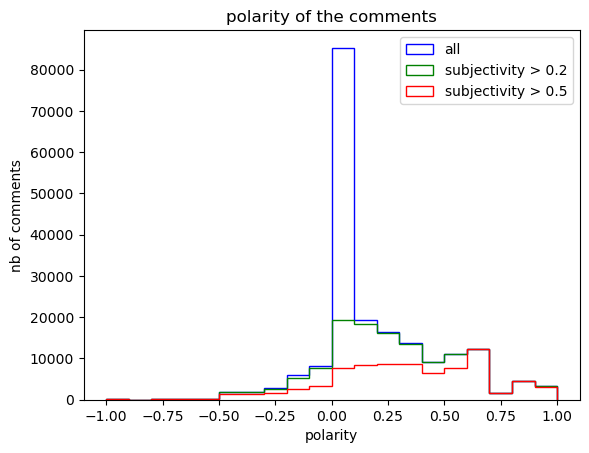

In [11]:
fig,ax = plt.subplots()
ax.hist(df["polarity"],bins=20, histtype="step", label='all',color='b')
df_subjectif = df[df['subjectivity'] > 0.2] 
ax.hist(df_subjectif["polarity"],bins=20, histtype="step", label='subjectivity > 0.2',color='g')
df_subjectif = df[df['subjectivity'] > 0.5] 
ax.hist(df_subjectif["polarity"],bins=20, histtype="step", label='subjectivity > 0.5',color='r')
plt.xlabel('polarity')
plt.ylabel('nb of comments')
plt.title('polarity of the comments')
plt.legend()
plt.show()

We can see that a lot of comment have 0 polarity because they are not subjective. We suppose that a lot of comments are too short to get any interesting information so we need to display the comments length for each subjectivity.

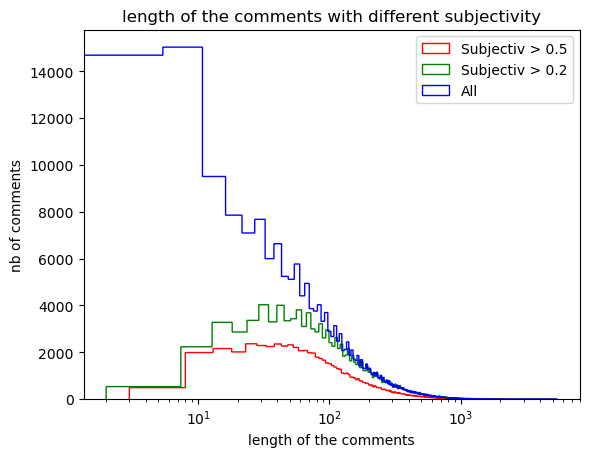

In [13]:
# graph of the length of the comments for all the comments (blue) and for the subjective comments (with more than 0.2 in green and 0.5 in red)
fig,ax = plt.subplots() 
ax.hist(df[df['subjectivity'] > 0.5]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.5',color='r')
ax.hist(df[df['subjectivity'] > 0.2]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.2',color='g')
ax.hist(df['CLE'].str.len(),bins=1000, histtype="step", label='All',color='b')
plt.xlabel('length of the comments')
plt.ylabel('nb of comments')
plt.title('length of the comments with different subjectivity')
plt.xscale('log')
plt.legend()
plt.show()

Many comments appear too brief to provide substantial information. To ensure meaningful insights, we have established a subjectivity threshold of 0.2. Consequently, during our comment exploration, we exclusively utilize the subjectiv dataframe. This focused approach aims to enhance the quality of our results by retaining only those comments deemed to be more interesting and informative.

In [14]:
#new df with only subjective comments for the rest of the code
df_subjectiv = df[df['subjectivity'] > 0.2] 

We want to see the distribution of the polarity across the vote results

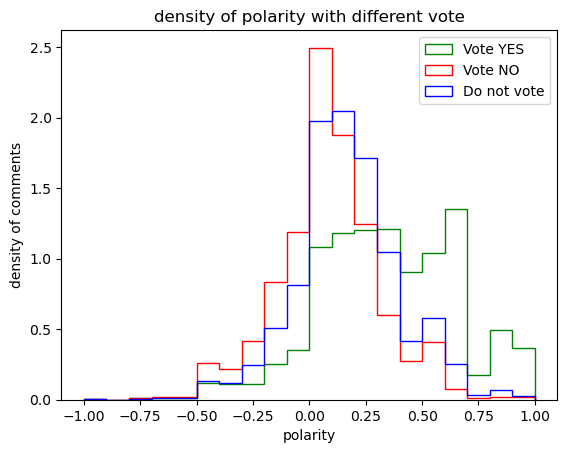

In [15]:
# graph show the density of the polarity for the vote "yes"-green, "neutral"-blue and "no"-red
fig,ax = plt.subplots() 
ax.hist(df_subjectiv[df_subjectiv['VOT'] == '1']["polarity"],bins=20, histtype="step", label='Vote YES',color='g', density=True)
ax.hist(df_subjectiv[df_subjectiv['VOT'] == '-1']["polarity"],bins=20, histtype="step", label='Vote NO',color='r', density=True)
ax.hist(df_subjectiv[df_subjectiv['VOT'] == '0']["polarity"],bins=20, histtype="step", label='Do not vote',color='b', density=True)
plt.xlabel('polarity')
plt.ylabel('density of comments')
plt.title('density of polarity with different vote')
plt.legend()
plt.show()

Those who cast positive votes exhibit higher polarity scores compared to those who vote neutrally, and subsequently, individuals who vote negatively tend to have lower polarity scores.

## Length of the comments

In this part, we want to see the correlation between the length of the comment and the subjectivity.

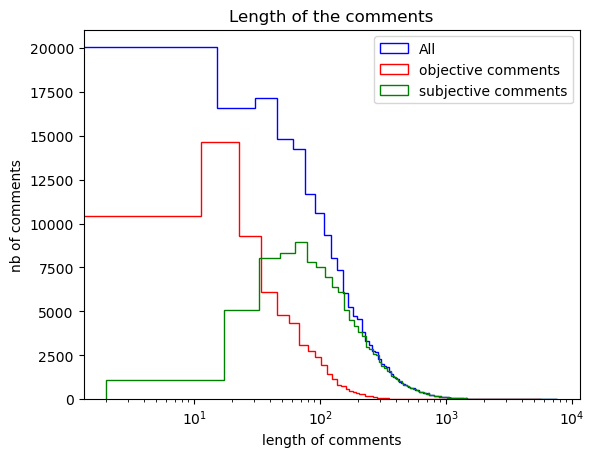

In [16]:
#lenght of all the comments (blue), length of all the subjective comments (green) and all the comments who are not subjective (red)
fig,ax = plt.subplots() 
ax.hist(df['TXT'].str.len(),bins=500, histtype="step", label='All',color='b')
ax.hist(df[df['subjectivity'] < 0.2]['TXT'].str.len(),bins=500, histtype="step", label='objective comments',color='r')
ax.hist(df[df['subjectivity'] > 0.2]['TXT'].str.len(),bins=500, histtype="step", label='subjective comments',color='g')
plt.xlabel('length of comments')
plt.ylabel('nb of comments')
plt.xscale('log')
plt.legend()
plt.title('Length of the comments')
plt.show()

We note that typically, when a comment is excessively brief, it tends to be objective. Conversely, when a comment is more extensive in terms of characters, it is likely to be subjective.

## Topic of the comments

In this part, we are going to use the latent dirichlet allocation who can help us to cluster the comments in various topics. The main idea is to extract some interesting keywords to know more about the comments. With that, we can understand what are the criteria for a succesful election.

We start with processing text with spacy

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
# preprocess text with lemmatization
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

In [19]:
# remove stop words
def process_stop_word(text, stem="None"):
    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']
    text_filtered = [word for word in text if not word in useless_words]
        # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [20]:
#clean the text for the LDA algorithm
df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)

C:\Users\liand\AppData\Local\Temp\ipykernel_16320\2594979675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
C:\Users\liand\AppData\Local\Temp\ipykernel_16320\2594979675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)


Transform the preprocessed comments into a structured representation that captures the importance of terms within each comment using TF-IDF (Term Frequency-Inverse Document Frequency).

In [21]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [22]:
#print the 10 words who represent the best each topics
def print_top_words(model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {' | '.join(top_words)}")

In [23]:
print_top_words(lda, vectorizer)

Topic #1: oppose | admin | article | user | support | candidate | editor | think | afd | policy
Topic #2: sorry | oppose | month | support | rfa | time | vote | think | good | neutral
Topic #3: answer | question | experience | good | ready | sound | oppose | support | need | major
Topic #4: good | look | excellent | editor | candidate | support | admin | like | contributor | nice
Topic #5: impressed | record | good | supportlook | track | impress | support | faith | levelheade | mean
Topic #6: great | user | good | work | admin | support | editor | guy | job | ok
Topic #7: strong | support | luck | tool | good | abuse | unlikely | admin | use | responsible
Topic #8: positive | net | interaction | project | helpful | friendly | support | asset | user | benefit
Topic #9: policy | content | knowledge | admin | good | work | support | understanding | experience | wikipedia
Topic #10: meet | big | deal | criterion | article | delete | support | standard | certainly | edit
Topic #11: impress

We can now had a topic number in the dataframe for all the comments :

In [24]:
#add a column with the number of the topic for each comment
df_subjectiv.reset_index(drop=True, inplace=True)
df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())
df_subjectiv.head()

C:\Users\liand\AppData\Local\Temp\ipykernel_16320\3148027325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())


,SRC,TGT,VOT,RES,YEA,DAT,TXT,CLE,polarity,subjectivity,preprocessed_txt,Topic
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,16
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",with great pleasure. i work with bdd at the gu...,0.638889,0.616667,great pleasure work bdd guild copy editor coor...,5
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,8
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,16
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,8


We can visualize the polarity of each topics :

C:\Users\liand\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Polarity of Different Topics')

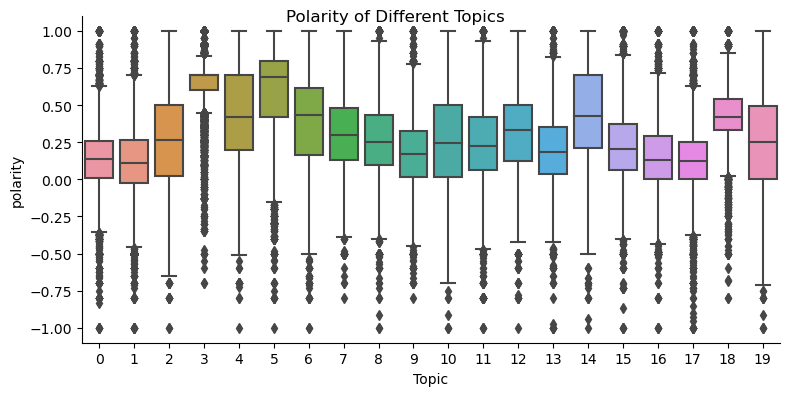

In [42]:
plot = sns.catplot(x='Topic', y='polarity', kind="box", data=df_subjectiv, errorbar='sd', height=4, aspect=2)
plot.fig.suptitle('Polarity of Different Topics')

By examining this plot, it becomes evident that topic 8 exhibits a higher polarity compared to the others. To delve deeper into the positive comments within this topic, we can inspect the list of prevalent words. Notable keywords include:
- positive
- interaction
- experienced
- helpful
- friendly
- project

After reflection, we anticipate uncovering more insights by filtering comments exclusively for positive or negative sentiments.

## Repeat the same with the positive/negative comments

In this part, we are gonna use only the subjective comments with a polarity greater than 0,5. The goal is to extract the topics and keywords to gives us an idea of the positive comments.

In [26]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [27]:
print_top_words(lda, vectorizer)

Topic #1: deserve | abuse | tool | good | supporti | admin | user | know | editor | great
Topic #2: user | experienced | good | great | support | sure | excellent | admin | helpful | experience
Topic #3: supporta | good | believe | afd | issue | admin | editor | intelligent | levelheade | support
Topic #4: editor | good | excellent | great | admin | support | impressive | time | honest | mop
Topic #5: answer | question | good | contribution | support | perfect | supportgood | response | great | judgement
Topic #6: work | great | admin | vandal | good | support | fighter | wikipedian | think | lot
Topic #7: impressed | administrator | good | person | support | kind | faith | great | way | excellent
Topic #8: edit | job | good | contribution | support | great | summary | history | vandalism | count
Topic #9: nice | guy | happy | support | addition | superb | good | great | vandalfighter | like
Topic #10: policy | impress | good | knowledge | understanding | support | brilliant | welcome 

Some other interesting positive words :
- qualified
- thrustworthy
- contribution
- experience
- levelheaded
- asset
- friendly
- contribution

These terms serve as valuable criterias to the acceptance of a person.

Then with the negative comments, with polarity smaller than -0,5.

In [28]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] < 0]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [29]:
print_top_words(lda, vectorizer)

Topic #1: ready | sorry | suggest | black | usual | early | experience | policy | oppose | close
Topic #2: oppose | mistake | pile | stupid | support | admin | learn | user | irc | candidate
Topic #3: weak | oppose | little | edit | experience | answer | support | sorry | mainspace | real
Topic #4: sure | positive | net | support | ridiculous | admin | think | editor | oppose | user
Topic #5: long | bad | support | time | overdue | oh | ago | moral | wait | faith
Topic #6: good | content | reason | interaction | negative | edit | oppose | creation | vandal | vague
Topic #7: vote | silly | support | oppose | ago | year | rfa | nt | month | track
Topic #8: sorry | support | oppose | soon | unnecessary | qualified | joke | thank | pileon | section
Topic #9: concern | major | issue | raise | oppose | sorry | csd | civility | past | support
Topic #10: deal | admin | big | oppose | user | editor | candidate | adminship | situation | article
Topic #11: wrong | edit | summary | low | count | s

From this word list, we can infer certain criteria indicative of non-acceptance:
- uncivil
- dangerous
- idiot
- stupid
- immature



## Which words are most frequently utilized in the comments?

In [30]:
all_text = ' '.join(df_subjectiv['preprocessed_txt'].astype(str))
all_text_p = ' '.join(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'].astype(str))
all_text_n = ' '.join(df_subjectiv[df_subjectiv['polarity'] < -0.5]['preprocessed_txt'].astype(str))

# Tokenize the text into words
words = re.findall(r'\b\w+\b', all_text.lower())
words_p = re.findall(r'\b\w+\b', all_text_p.lower())
words_n = re.findall(r'\b\w+\b', all_text_n.lower())


# count occurrences of each word
word_counts = Counter(words)
word_counts_p = Counter(words_p)
word_counts_n = Counter(words_n)

# Print the most common words and their counts for all/positive/negative comments
print('most common words in all the comments : \n', word_counts.most_common(20),'\n')
print('most common words the positive comments : \n', word_counts_p.most_common(20),'\n')
print('most common words the negative comments : \n', word_counts_n.most_common(20),'\n')

most common words in all the comments : 
 [('good', 45056), ('support', 42443), ('admin', 35350), ('edit', 26957), ('user', 25202), ('oppose', 24113), ('editor', 22283), ('candidate', 18422), ('work', 18105), ('think', 17157), ('tool', 16284), ('experience', 16140), ('like', 15166), ('time', 14377), ('answer', 14362), ('article', 14052), ('need', 13377), ('rfa', 13286), ('great', 12446), ('wikipedia', 12326)] 

most common words the positive comments : 
 [('good', 18075), ('support', 7442), ('great', 5913), ('admin', 5390), ('editor', 4835), ('user', 4233), ('excellent', 3767), ('candidate', 3079), ('work', 2910), ('look', 2738), ('answer', 2303), ('like', 2076), ('tool', 2048), ('luck', 1903), ('edit', 1710), ('question', 1567), ('see', 1553), ('contribution', 1553), ('think', 1467), ('experience', 1441)] 

most common words the negative comments : 
 [('bad', 174), ('support', 125), ('oppose', 101), ('admin', 87), ('hate', 51), ('user', 49), ('think', 43), ('tool', 41), ('reason', 39)